<a href="https://colab.research.google.com/github/glf58/Projet_Covid/blob/GLF/permiermodele_ffd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import shutil
import datetime 
import tensorflow

from google.colab import drive
from zipfile import ZipFile

from sklearn.metrics import classification_report

from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomHeight, RandomWidth, RandomTranslation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## on importe le drive local duquel on copie les data dans l'environnement colab '/content' qui disparaitra a la fin de la session

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
path_out = '/content/C19'                                                             #chemin dans l'env. colab ou on va copier les data
histo_equalize = False                                                                # sert a definir le type de donnees a utliser:  True: on recupere les images dont les histogrammes ont ete prealablement harmonises
                                                                                      #                                               False: on recupere les images originales

if histo_equalize:
  archive = '/content/drive/MyDrive/kaggle/covid19-histo_equal-dataset_for_ffd.zip'   # chemin de l'archive qui contient les donnees melangees au bon format pour ffd avec histogramme egalises
else:
  archive='/content/drive/MyDrive/kaggle/covid19--dataset_for_ffd.zip'                 # chemin de l'archive qui contient les donnees originales melangees au bon format pour ffd 
#on supprime le precedent s'il existe et on cree le repertoire pour accueillir les donnees
shutil.rmtree(path_out, ignore_errors=True)
os.mkdir(path_out)
with ZipFile(archive, 'r') as zip_ref:
  zip_ref.extractall(path_out)

## Static data utiles pour le programme

In [4]:
data_types=['Test', 'Validation', 'Train']
cats = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
initial_size = (299,299)  #taille initiale des images
target_size = (299,299)   #redimensionnement des images
training_bs = 32          #batch size pour entrainement/validation
image_augmentation = False #couches d'augmentation d'image dans le modele
rotation_factor = 0.1
zoom_factor = 0.1
contrast_factor = 0.1
width_factor = 0.1
height_factor = 0.1
flip = 'horizontal_and_vertical'

# parametres du premier modele simple
n_filters=8              #nb de filtes de convolution dans la premiere couche; le nb de filtre est x2 pour chaque couche supplementaire
dropout_rate=0.2         #taux de drop_out apres 
n_dense=2                #nb de couche dense apres la convolution
n_units=32               #nb de neurones pour chaque couche dense

## Verification des repertoires et des images

In [5]:
n_data_by_type = []
for data_type in data_types:
  n = 0
  print(data_type)
  for cat in cats:    
    print('la categorie {} possede {} images'.format(cat,len(os.listdir(os.path.join(path_out, data_type, cat)))))
    n += len(os.listdir(os.path.join(path_out, data_type, cat)))
  print('le nb total d\'images dans {} est {}'.format(data_type, n))
# on calcule le nb d'images par classes sur l'ensemble d'entrainement et on pondere chaque classe par 1/nb d'elements dans la classe pour equilibrer le dataset
n_images_train = 0
class_weights = {}
for i, cat in enumerate(cats):
  n_train_cat = len(os.listdir(os.path.join(path_out, 'Train', cat)))
  n_images_train += n_train_cat
  class_weights[i] = 1 / n_train_cat
for i in range(len(cats)):
  class_weights[i] = n_train_cat * class_weights[i]
print("class_weights utilisera les poids suivants:", class_weights)

Test
la categorie COVID possede 542 images
la categorie Lung_Opacity possede 901 images
la categorie Normal possede 1528 images
la categorie Viral Pneumonia possede 201 images
le nb total d'images dans Test est 3172
Validation
la categorie COVID possede 542 images
la categorie Lung_Opacity possede 901 images
la categorie Normal possede 1528 images
la categorie Viral Pneumonia possede 201 images
le nb total d'images dans Validation est 3172
Train
la categorie COVID possede 2531 images
la categorie Lung_Opacity possede 4209 images
la categorie Normal possede 7135 images
la categorie Viral Pneumonia possede 942 images
le nb total d'images dans Train est 14817
class_weights utilisera les poids suivants: {0: 0.3721849071513236, 1: 0.22380612972202424, 2: 0.13202522775052558, 3: 1.0}


## creation des data_generator

In [6]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()                                  
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(directory=os.path.join(path_out,'Train'),
                                                    color_mode='grayscale',
                                                    class_mode='sparse', 
                                                    target_size=target_size,
                                                    batch_size=training_bs,
                                                    )

validation_generator = val_datagen.flow_from_directory(directory=os.path.join(path_out,'Validation'),
                                                         color_mode='grayscale',
                                                         class_mode='sparse', 
                                                         target_size=target_size,
                                                         batch_size=training_bs,
                                                         )

test_generator = test_datagen.flow_from_directory(directory=os.path.join(path_out,'Test'),
                                                  color_mode='grayscale',
                                                  class_mode='sparse', 
                                                  target_size=target_size,
                                                  shuffle = False, 
                                                  batch_size=1)


Found 14817 images belonging to 4 classes.
Found 3172 images belonging to 4 classes.
Found 3172 images belonging to 4 classes.


## on peut verifier la repartition des classes dans chacun des groupes

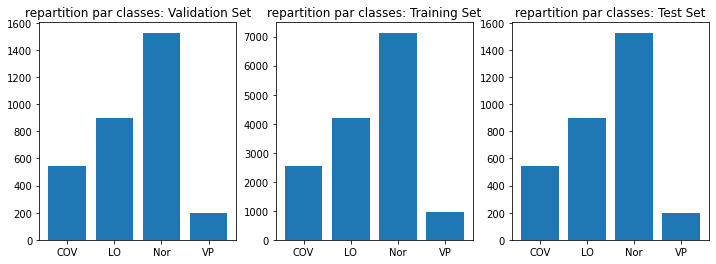

In [7]:
classes_val, n_classes_val = np.unique(validation_generator.labels, return_counts=True)
classes_train, n_classes_train = np.unique(train_generator.labels, return_counts=True)
classes_test, n_classes_test = np.unique(test_generator.labels, return_counts=True)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('repartition par classes: Validation Set')
plt.bar(classes_val, n_classes_val)
plt.xticks(classes_val, ['COV', 'LO', 'Nor', 'VP'])
plt.subplot(132)
plt.title('repartition par classes: Training Set')
plt.bar(classes_train, n_classes_train)
plt.xticks(classes_train, ['COV', 'LO', 'Nor', 'VP'])
plt.subplot(133)
plt.title('repartition par classes: Test Set')
plt.bar(classes_test, n_classes_test)
plt.xticks(classes_test, ['COV', 'LO', 'Nor', 'VP'])

if False:
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/covid/modeles/repartition_data.png')

plt.show()

## creation des couches d'augmentation d'images
On le fait dans le modele directement, cela est plus rapide avec le GPU

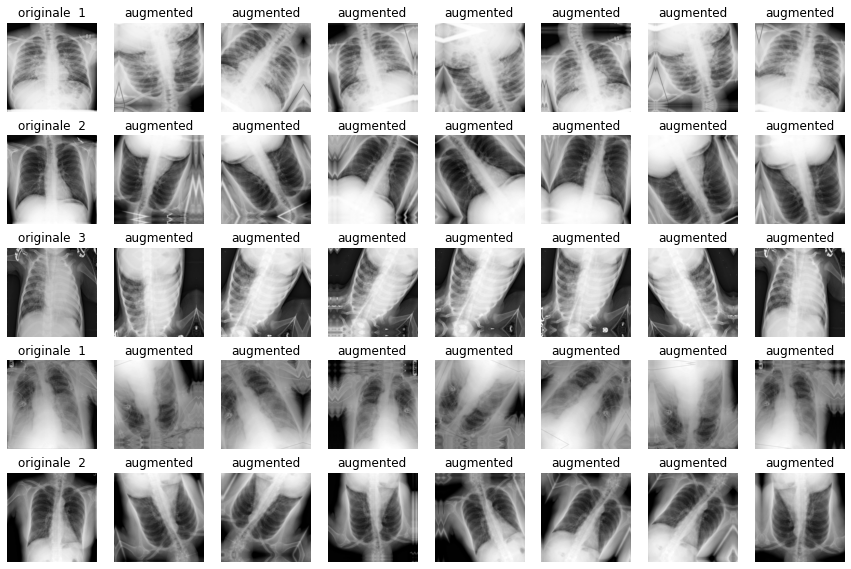

In [8]:
data_augmentation = Sequential(
    [
        RandomFlip(flip),
        RandomRotation(rotation_factor),
        #RandomRotation(0.1),
        #RandomZoom(0.8),
        RandomZoom(zoom_factor),
        #RandomContrast(contrast_factor),
        #RandomContrast(0.1),
        #RandomHeight(0.2), 
        #RandomWidth(0.2),
        RandomTranslation(height_factor,width_factor),
        #RandomTranslation(0.2,0.2),
    ]
)
#data_augmentation.build(input_shape=(target_size[0], target_size[1], 1))

nb_img = 5
nb_transformation = 7
fig, axs = plt.subplots(nb_img, nb_transformation+1, figsize=(15,10))

train_generator.reset()
for row in range(nb_img):
  images, labels = train_generator.next()
  #indice = np.random.randint(images.shape[0])
  img = images[0].reshape(target_size)
  axs[row, 0].imshow(img, cmap='gray')
  axs[row, 0].axis('off')
  axs[row, 0].set_title('originale  '+str(int(labels[0])))
  for col in range(1,nb_transformation+1):
    augmented_images = data_augmentation(images)
    img = augmented_images[0].numpy().astype("uint8")
    axs[row, col].imshow(img.reshape(img.shape[0],img.shape[1]), cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title('augmented')

train_generator.reset()

# !!!! ne pas utiliser randomcontrast qui va generer des taches blanches et noires


#Creation du modele

In [9]:
def build_first_model(n_filters, dropout_rate, n_dense, n_units, loss='categorical_crossentropy', summary=False):
    mod = Sequential()
    mod.add(Input(shape = [target_size[0],target_size[1], 1]))    
    if image_augmentation:
      mod.add(data_augmentation)
    mod.add(Rescaling(1./255))
    mod.add(Conv2D(filters=n_filters, kernel_size=(5,5), activation='relu', padding='valid'))
    mod.add(MaxPooling2D(pool_size=(2,2)))
    mod.add(Conv2D(filters=n_filters*2, kernel_size=(3,3), activation='relu', padding='valid'))
    mod.add(MaxPooling2D(pool_size=(2,2)))
    mod.add(Conv2D(filters=n_filters*4, kernel_size=(3,3), activation='relu', padding='valid'))
    mod.add(MaxPooling2D(pool_size=(2,2)))
    mod.add(Dropout(rate=dropout_rate))
    mod.add(Flatten())
    for i in range(n_dense):
        mod.add(Dense(units=n_units, activation='relu'))
        mod.add(Dropout(rate=dropout_rate))
    mod.add(Dense(units = 4, activation='softmax'))
      
    mod.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    if summary:
      mod.summary()

    return(mod)

lenet = build_first_model(n_filters=n_filters, dropout_rate=dropout_rate, n_dense=n_dense, n_units=n_units, loss='sparse_categorical_crossentropy', summary=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 295, 295, 8)       208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 147, 147, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 145, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 72, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 70, 70, 32)       

## entrainement du modele

In [10]:
es = EarlyStopping(monitor="val_loss",
                   min_delta=0.001,
                   patience=4,
                   mode="min",
                   restore_best_weights=True, 
                   verbose=1)

red_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.5, 
                           patience=2, 
                           min_delta = 0.01, 
                           #cooldown=3, 
                           verbose=1)

training_history_lenet = lenet.fit_generator(train_generator, 
                                             epochs=50,
                                             steps_per_epoch = train_generator.samples//train_generator.batch_size,
                                             validation_data = validation_generator,
                                             validation_steps = validation_generator.samples//validation_generator.batch_size,
                                             class_weight=class_weights,
                                             callbacks=[es, red_lr]
                                             )



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
463/463 [==============================] - 66s 120ms/step - loss: 0.2311 - accuracy: 0.5648 - val_loss: 0.6768 - val_accuracy: 0.7128 - lr: 0.0010
Epoch 2/50
463/463 [==============================] - 51s 109ms/step - loss: 0.1583 - accuracy: 0.7034 - val_loss: 0.6146 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 3/50
463/463 [==============================] - 54s 116ms/step - loss: 0.1435 - accuracy: 0.7293 - val_loss: 0.5040 - val_accuracy: 0.8024 - lr: 0.0010
Epoch 4/50
463/463 [==============================] - 53s 114ms/step - loss: 0.1204 - accuracy: 0.7698 - val_loss: 0.4454 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 5/50
463/463 [==============================] - 53s 114ms/step - loss: 0.1076 - accuracy: 0.7933 - val_loss: 0.4627 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 6/50
463/463 [==============================] - 52s 113ms/step - loss: 0.0987 - accuracy: 0.8078 - val_loss: 0.4293 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 7/50
463/463 [==============================] 

In [11]:
 def show_training_model(hist, save=False, mod='mod'):
    fig = plt.figure(figsize=(10,5))
    epochs = len(hist.history['accuracy'])
    ax1 = fig.add_subplot(121)
    ax1.plot(np.arange(1,epochs+1,1), hist.history['accuracy'], 'blue', label='training')
    ax1.plot(np.arange(1,epochs+1,1), hist.history['val_accuracy'], 'r', label='validation')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    ax1.legend()
    ax2 = fig.add_subplot(122)
    ax2.plot(np.arange(1,epochs+1,1), hist.history['loss'], 'blue', label='training')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax3 = ax2.twinx()
    ax3.plot(np.arange(1,epochs+1,1), hist.history['val_loss'], 'r', label='validation')
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('Loss')
    ax3.legend(loc='upper left')
    if save:
        plt.savefig(mod+'.png')

/content/drive/MyDrive/Colab Notebooks/covid/modeles/lenet2x32


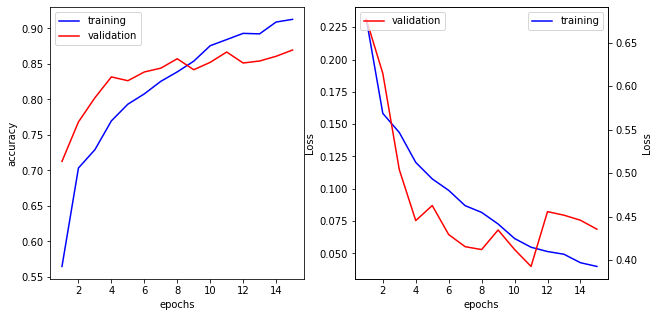

In [12]:
if histo_equalize:
  eq = 'HE'
else:
  eq = ''
if image_augmentation:
  ia = 'IA'
else:
  ia = ''
name = '/content/drive/MyDrive/Colab Notebooks/covid/modeles/lenet2x'+str(n_units)+eq+ia
print(name)
show_training_model(training_history_lenet, save=True, mod=name)

## Rergardons la performance du modele sur l'ensemble de test

In [13]:
def perf_model_on_test(mod, test_generator):
#  print("performance du modele sur ensemble de test:", mod.evaluate(test_generator)[1])
  y_pred = mod.predict(x=test_generator, 
                         steps=test_generator.samples//test_generator.batch_size, 
                         verbose=1)
  y_pred_class = np.argmax(y_pred, axis=1)
  y_test_class = test_generator.labels
  report = classification_report(y_test_class, y_pred_class)
  cm = pd.crosstab(y_test_class, y_pred_class, rownames=['realite'], colnames=['prediction'])

  return report, cm

In [14]:
cr, cm = perf_model_on_test(lenet, test_generator)
print(cr)
print(cm)

3172/3172 [==============================] - 15s 5ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       542
           1       0.84      0.81      0.82       901
           2       0.88      0.90      0.89      1528
           3       0.93      0.94      0.93       201

    accuracy                           0.87      3172
   macro avg       0.88      0.88      0.88      3172
weighted avg       0.87      0.87      0.87      3172

prediction    0    1     2    3
realite                        
0           468   34    38    2
1            36  726   138    1
2            37  104  1375   12
3             2    2     9  188


In [15]:
def save_config_and_model_results(n_filters, dropout_rate, n_dense, n_units, train_hist, class_report, confusion_matrix, name):
  res = {}
  res['date'] = str(datetime.datetime.today()).split()[0]
  res['target_size'] = target_size   
  res['Nmax'] = 11200
  res['histo_equalize'] = histo_equalize
  res['image_augmentation'] = image_augmentation
  res['rotation_factor'] = rotation_factor
  res['zoom_factor'] = zoom_factor
  res['contrast_factor'] = contrast_factor
  res['flip'] = flip
  res['val_split'] = 15
  res['test_split'] = 15
  res['hist'] = train_hist.history
  res['cr'] = class_report
  res['confusion_matrix'] = confusion_matrix
  res['n_filters'] = n_filters
  res['drop_out'] = dropout_rate
  res['n_dense'] = n_dense
  res['n_units'] = n_units
  np.save(name, res)

In [16]:

save_config_and_model_results(n_filters, dropout_rate, n_dense, n_units,training_history_lenet, cr, cm, name+'.npy')


In [17]:
 #verification

new_dict = np.load(name+'.npy', allow_pickle='TRUE').item()

cr1 = new_dict['cr']

print(cr1)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       542
           1       0.84      0.81      0.82       901
           2       0.88      0.90      0.89      1528
           3       0.93      0.94      0.93       201

    accuracy                           0.87      3172
   macro avg       0.88      0.88      0.88      3172
weighted avg       0.87      0.87      0.87      3172



In [18]:
new_dict['hist']['val_accuracy']

[0.7127525210380554,
 0.7683081030845642,
 0.8023989796638489,
 0.8317550420761108,
 0.8263888955116272,
 0.8386995196342468,
 0.8440656661987305,
 0.8573232293128967,
 0.841856062412262,
 0.8522727489471436,
 0.8667929172515869,
 0.8513257503509521,
 0.8541666865348816,
 0.8607954382896423,
 0.8696338534355164]